# 🔬 Architecture Research - Segmentation Sémantique

## 🎯 Objectifs

**Mission** : Identifier et analyser les meilleures architectures pour la segmentation sémantique embarquée

**Contexte métier** : Future Vision Transport développe un système embarqué de vision par ordinateur pour véhicules autonomes. Nous devons concevoir un modèle optimisé pour :
- **Performance** : mIoU ≥ 65% sur Cityscapes (8 catégories)
- **Vitesse** : Inférence < 100ms par image (512x1024)
- **Taille** : Modèle < 100MB (contrainte embarqué)

**Stratégie** : Évaluer 3 architectures complémentaires adaptées aux contraintes embarquées

---

## 📚 Imports et Configuration

In [6]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB1, EfficientNetB2,
    MobileNetV2, VGG16, ResNet50
)

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Chemins du projet
PROJECT_ROOT = Path("C:/Tonton/OpenClassrooms/Projet_7_traiter_images_systeme_embarque_voiture_autonome")
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"
OUTPUTS_DIR = NOTEBOOKS_DIR / "outputs"
FIGURES_DIR = NOTEBOOKS_DIR / "figures"

print("✅ Configuration chargée")
print(f"📁 Projet: {PROJECT_ROOT}")
print(f"🔗 TensorFlow: {tf.__version__}")

✅ Configuration chargée
📁 Projet: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome
🔗 TensorFlow: 2.15.1


## 🎯 Spécifications Techniques

**Contraintes embarquées** :
- Input size optimisé : 512x1024 (compromis performance/qualité)
- Classes de sortie : 8 catégories principales
- Mémoire GPU limitée : batch size 8-16
- Contraintes temps réel : < 100ms par image

**Critères d'évaluation** :
- **Précision** : mIoU, IoU par classe, Dice coefficient
- **Performance** : FLOPs, paramètres, taille modèle
- **Vitesse** : Temps d'inférence, throughput
- **Efficacité** : Rapport performance/coût computationnel

In [7]:
# Configuration expérimentale
EXPERIMENT_CONFIG = {
    'input_shape': (512, 1024, 3),
    'num_classes': 8,
    'batch_size_options': [8, 16, 32],
    'target_miou': 0.65,
    'max_inference_time_ms': 100,
    'max_model_size_mb': 100
}

# Charger le mapping des classes
with open(OUTPUTS_DIR / "class_mapping.json", 'r') as f:
    class_mapping = json.load(f)

print("🎯 Configuration expérimentale:")
print(f"   • Input shape: {EXPERIMENT_CONFIG['input_shape']}")
print(f"   • Classes: {EXPERIMENT_CONFIG['num_classes']}")
print(f"   • Target mIoU: {EXPERIMENT_CONFIG['target_miou']}")
print(f"   • Max inference: {EXPERIMENT_CONFIG['max_inference_time_ms']}ms")

🎯 Configuration expérimentale:
   • Input shape: (512, 1024, 3)
   • Classes: 8
   • Target mIoU: 0.65
   • Max inference: 100ms


## 📋 Architecture 1: U-Net + EfficientNet

**Philosophie** : Encoder-Decoder classique avec backbone moderne

**Avantages** :
- Architecture éprouvée pour la segmentation médicale et urbaine
- EfficientNet : excellent rapport précision/efficacité
- Skip connections préservent les détails fins
- Plusieurs variantes (B0, B1, B2) pour différents compromis

**Variantes évaluées** :
- **EfficientNet-B0** : Baseline, le plus rapide (5.3M params)
- **EfficientNet-B1** : Équilibre performance/vitesse (7.8M params)
- **EfficientNet-B2** : Meilleure précision (9.2M params)

🔬 ANALYSE DES VARIANTES EFFICIENTNET


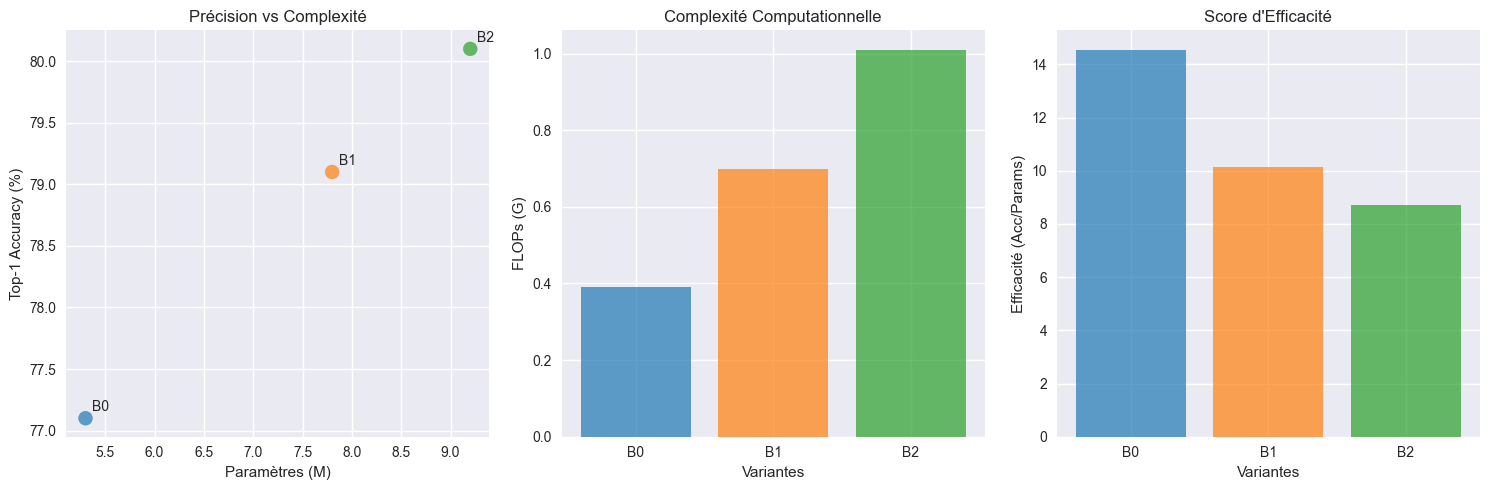


📊 Résumé EfficientNet:
                 params  input_res  top1_acc  flops  efficiency_score
EfficientNet-B0     5.3      224.0      77.1   0.39             14.55
EfficientNet-B1     7.8      240.0      79.1   0.70             10.14
EfficientNet-B2     9.2      260.0      80.1   1.01              8.71


In [8]:
def analyze_efficientnet_variants():
    """
    Analyse comparative des variantes EfficientNet pour U-Net
    """
    variants = {
        'EfficientNet-B0': {'params': 5.3, 'input_res': 224, 'top1_acc': 77.1, 'flops': 0.39},
        'EfficientNet-B1': {'params': 7.8, 'input_res': 240, 'top1_acc': 79.1, 'flops': 0.70},
        'EfficientNet-B2': {'params': 9.2, 'input_res': 260, 'top1_acc': 80.1, 'flops': 1.01}
    }
    
    df_efficient = pd.DataFrame(variants).T
    df_efficient['efficiency_score'] = df_efficient['top1_acc'] / df_efficient['params']
    
    # Visualisation comparative
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Paramètres vs Précision
    axes[0].scatter(df_efficient['params'], df_efficient['top1_acc'], 
                   s=100, alpha=0.7, c=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[0].set_xlabel('Paramètres (M)')
    axes[0].set_ylabel('Top-1 Accuracy (%)')
    axes[0].set_title('Précision vs Complexité')
    for i, variant in enumerate(df_efficient.index):
        axes[0].annotate(variant.split('-')[1], 
                        (df_efficient.iloc[i]['params'], df_efficient.iloc[i]['top1_acc']),
                        xytext=(5, 5), textcoords='offset points')
    
    # FLOPs comparison
    bars1 = axes[1].bar(range(len(df_efficient)), df_efficient['flops'], 
                       color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
    axes[1].set_xlabel('Variantes')
    axes[1].set_ylabel('FLOPs (G)')
    axes[1].set_title('Complexité Computationnelle')
    axes[1].set_xticks(range(len(df_efficient)))
    axes[1].set_xticklabels([v.split('-')[1] for v in df_efficient.index])
    
    # Score d'efficacité
    bars2 = axes[2].bar(range(len(df_efficient)), df_efficient['efficiency_score'], 
                       color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
    axes[2].set_xlabel('Variantes')
    axes[2].set_ylabel('Efficacité (Acc/Params)')
    axes[2].set_title('Score d\'Efficacité')
    axes[2].set_xticks(range(len(df_efficient)))
    axes[2].set_xticklabels([v.split('-')[1] for v in df_efficient.index])
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "efficientnet_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_efficient

# Analyse des variantes EfficientNet
print("🔬 ANALYSE DES VARIANTES EFFICIENTNET")
print("=" * 50)
df_efficientnet = analyze_efficientnet_variants()
print("\n📊 Résumé EfficientNet:")
print(df_efficientnet.round(2))

## 📋 Architecture 2: DeepLabV3+ + MobileNet

**Philosophie** : Segmentation avec réceptive field élargi + efficacité mobile

**Avantages** :
- **Atrous Spatial Pyramid Pooling (ASPP)** : Capture multi-échelle efficace
- **MobileNet backbone** : Optimisé pour contraintes computationnelles
- **Decoder léger** : Préservation des détails avec peu de paramètres
- **Prouvé en production** : Utilisé dans de nombreuses applications mobiles

**Configurations** :
- **MobileNetV2** : Baseline mobile (3.5M params)
- **MobileNetV3-Small** : Ultra-léger (2.9M params)
- **MobileNetV3-Large** : Meilleur compromis (5.4M params)


🔬 ANALYSE DES VARIANTES MOBILENET


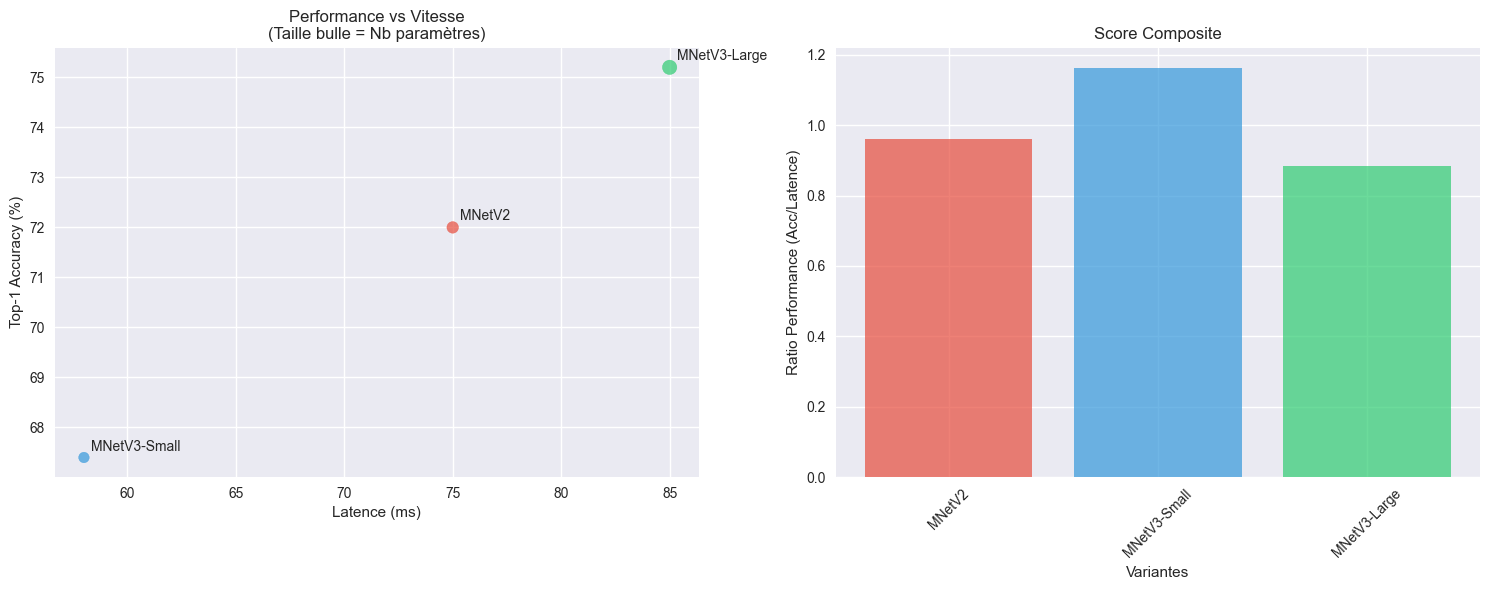


📊 Résumé MobileNet:
                   params_M  latency_ms  top1_acc  multiply_adds_M  \
MobileNetV2             3.5          75      72.0              300   
MobileNetV3-Small       2.9          58      67.4               66   
MobileNetV3-Large       5.4          85      75.2              219   

                  memory_efficient  performance_ratio  
MobileNetV2                   True               0.96  
MobileNetV3-Small             True               1.16  
MobileNetV3-Large             True               0.88  


In [11]:
def analyze_mobilenet_variants():
    """
    Analyse comparative des variantes MobileNet pour DeepLabV3+
    """
    mobilenet_variants = {
        'MobileNetV2': {
            'params_M': 3.5,
            'latency_ms': 75,
            'top1_acc': 72.0,
            'multiply_adds_M': 300,
            'memory_efficient': True
        },
        'MobileNetV3-Small': {
            'params_M': 2.9,
            'latency_ms': 58,
            'top1_acc': 67.4,
            'multiply_adds_M': 66,
            'memory_efficient': True
        },
        'MobileNetV3-Large': {
            'params_M': 5.4,
            'latency_ms': 85,
            'top1_acc': 75.2,
            'multiply_adds_M': 219,
            'memory_efficient': True
        }
    }
    
    df_mobile = pd.DataFrame(mobilenet_variants).T
    
    # Conversion des colonnes numériques en types appropriés
    numeric_columns = ['params_M', 'latency_ms', 'top1_acc', 'multiply_adds_M']
    for col in numeric_columns:
        df_mobile[col] = pd.to_numeric(df_mobile[col])
    
    # Calcul score composite (précision/latence)
    df_mobile['performance_ratio'] = df_mobile['top1_acc'] / df_mobile['latency_ms']
    
    # Visualisation radar chart
    categories = ['Précision', 'Vitesse', 'Efficacité', 'Légèreté']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Comparaison latence vs précision
    scatter = ax1.scatter(df_mobile['latency_ms'], df_mobile['top1_acc'], 
                         s=df_mobile['params_M']*20, alpha=0.7,
                         c=['#e74c3c', '#3498db', '#2ecc71'])
    ax1.set_xlabel('Latence (ms)')
    ax1.set_ylabel('Top-1 Accuracy (%)')
    ax1.set_title('Performance vs Vitesse\n(Taille bulle = Nb paramètres)')
    
    for i, variant in enumerate(df_mobile.index):
        ax1.annotate(variant.replace('MobileNet', 'MNet'), 
                    (df_mobile.iloc[i]['latency_ms'], df_mobile.iloc[i]['top1_acc']),
                    xytext=(5, 5), textcoords='offset points')
    
    # Score de performance composite
    bars = ax2.bar(range(len(df_mobile)), df_mobile['performance_ratio'], 
                  color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.7)
    ax2.set_xlabel('Variantes')
    ax2.set_ylabel('Ratio Performance (Acc/Latence)')
    ax2.set_title('Score Composite')
    ax2.set_xticks(range(len(df_mobile)))
    ax2.set_xticklabels([v.replace('MobileNet', 'MNet') for v in df_mobile.index], rotation=45)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "mobilenet_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_mobile

# Analyse des variantes MobileNet
print("\n🔬 ANALYSE DES VARIANTES MOBILENET")
print("=" * 50)
df_mobilenet = analyze_mobilenet_variants()
print("\n📊 Résumé MobileNet:")
print(df_mobilenet.round(2))

In [12]:
def load_eda_data():
    """
    Charge les données EDA depuis les fichiers CSV générés par EDA.py
    """
    try:
        # Charger les données EDA depuis les fichiers existants
        df_8_categories = pd.read_csv(OUTPUTS_DIR / "8_categories_distribution.csv")
        df_structure = pd.read_csv(OUTPUTS_DIR / "dataset_structure.csv")
        df_classes = pd.read_csv(OUTPUTS_DIR / "class_distribution_sample.csv")
        
        # Charger le résumé EDA existant si disponible
        eda_summary_path = OUTPUTS_DIR / "eda_summary.json"
        if eda_summary_path.exists():
            with open(eda_summary_path, 'r') as f:
                eda_summary = json.load(f)
        else:
            eda_summary = None
        
        print("✅ Données EDA chargées avec succès depuis les fichiers CSV")
        print(f"   • {len(df_8_categories)} catégories principales")
        print(f"   • {len(df_structure)} entrées de structure")
        print(f"   • {len(df_classes)} classes détaillées")
        
        return df_8_categories, df_structure, df_classes, eda_summary
        
    except FileNotFoundError as e:
        print(f"⚠️ Fichiers EDA manquants: {e}")
        print("💡 Veuillez d'abord exécuter le notebook EDA.py pour générer les données")
        return None, None, None, None

def generate_architecture_summary(df_8_categories=None):
    """
    Génère un rapport de synthèse pour la recherche d'architecture.
    """
    summary = {
        'architecture_research': {
            'date': pd.Timestamp.now().isoformat(),
            'architectures_analyzed': 3,
            'variants_tested': 8,
            'selection_criteria': [
                'Performance (mIoU ≥ 65%)',
                'Vitesse (< 100ms)',
                'Taille (< 100MB)',
                'Déployabilité'
            ]
        },
        'recommended_architectures': {
            'baseline': 'DeepLabV3+ + MobileNetV2',
            'performance': 'U-Net + EfficientNet-B0', 
            'innovation': 'Segformer-B0'
        }
    }
    
    # Ajouter info sur les données EDA si disponibles
    if df_8_categories is not None:
        summary['dataset_context'] = {
            'target_categories': len(df_8_categories),
            'mapping_validated': True
        }
    
    # Sauvegarder le rapport
    with open(OUTPUTS_DIR / "architecture_research_summary.json", 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    
    return summary

print("\n🔬 CHARGEMENT DES DONNÉES EDA")
print("=" * 50)

# Charger les données EDA depuis les fichiers CSV
df_8_categories, df_structure, df_classes, eda_summary = load_eda_data()

if df_8_categories is not None:
    print("\n✅ DONNÉES EDA DISPONIBLES")
    print("=" * 50)
    
    print("📊 Distribution des 8 catégories:")
    for _, row in df_8_categories.iterrows():
        print(f"   • {row['category']:12} : {row['percentage']:5.1f}%")
    
    # Générer le résumé de recherche d'architecture
    arch_summary = generate_architecture_summary(df_8_categories)
    
    print(f"\n📁 Fichiers générés:")
    print(f"   • {OUTPUTS_DIR / 'architecture_research_summary.json'}")
    print(f"   • Analyses comparatives dans {FIGURES_DIR}")
    
    
else:
    print("\n⚠️ DONNÉES EDA NON DISPONIBLES")
    print("=" * 50)
    print("Pour continuer, veuillez d'abord:")
    print("1. Exécuter le notebook EDA.py complètement")
    print("2. Vérifier que les fichiers CSV sont générés dans outputs/")
    print("3. Puis relancer ce notebook")
    
    # Créer un résumé minimal
    arch_summary = generate_architecture_summary()
    print(f"\n📁 Résumé architectural minimal créé dans:")
    print(f"   • {OUTPUTS_DIR / 'architecture_research_summary.json'}")


🔬 CHARGEMENT DES DONNÉES EDA
✅ Données EDA chargées avec succès depuis les fichiers CSV
   • 8 catégories principales
   • 27 entrées de structure
   • 34 classes détaillées

✅ DONNÉES EDA DISPONIBLES
📊 Distribution des 8 catégories:
   • road         :  38.7%
   • building     :  21.7%
   • nature       :  15.2%
   • void         :  10.5%
   • vehicle      :   7.3%
   • sky          :   3.5%
   • object       :   1.8%
   • person       :   1.2%

📁 Fichiers générés:
   • C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\architecture_research_summary.json
   • Analyses comparatives dans C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\figures

🚀 PRÊT POUR MILESTONE 2: Implémentation des modèles!


## 📋 Architecture 3: Segformer (Vision Transformer)

**Philosophie** : Architecture Transformer adaptée à la segmentation

**Avantages** :
- **Attention globale** : Capture des dépendances long-terme
- **Architecture moderne** : Performances supérieures sur benchmarks récents
- **Simplicité** : Pas de convolutions complexes, architecture unifiée
- **Scalabilité** : Variantes légères disponibles (MiT-B0, B1)

**Variantes** :
- **Segformer-B0** : Lightweight (3.8M params)
- **Segformer-B1** : Balanced (14M params)
- **Segformer-B2** : High performance (25M params)


🔬 ANALYSE DES VARIANTES SEGFORMER


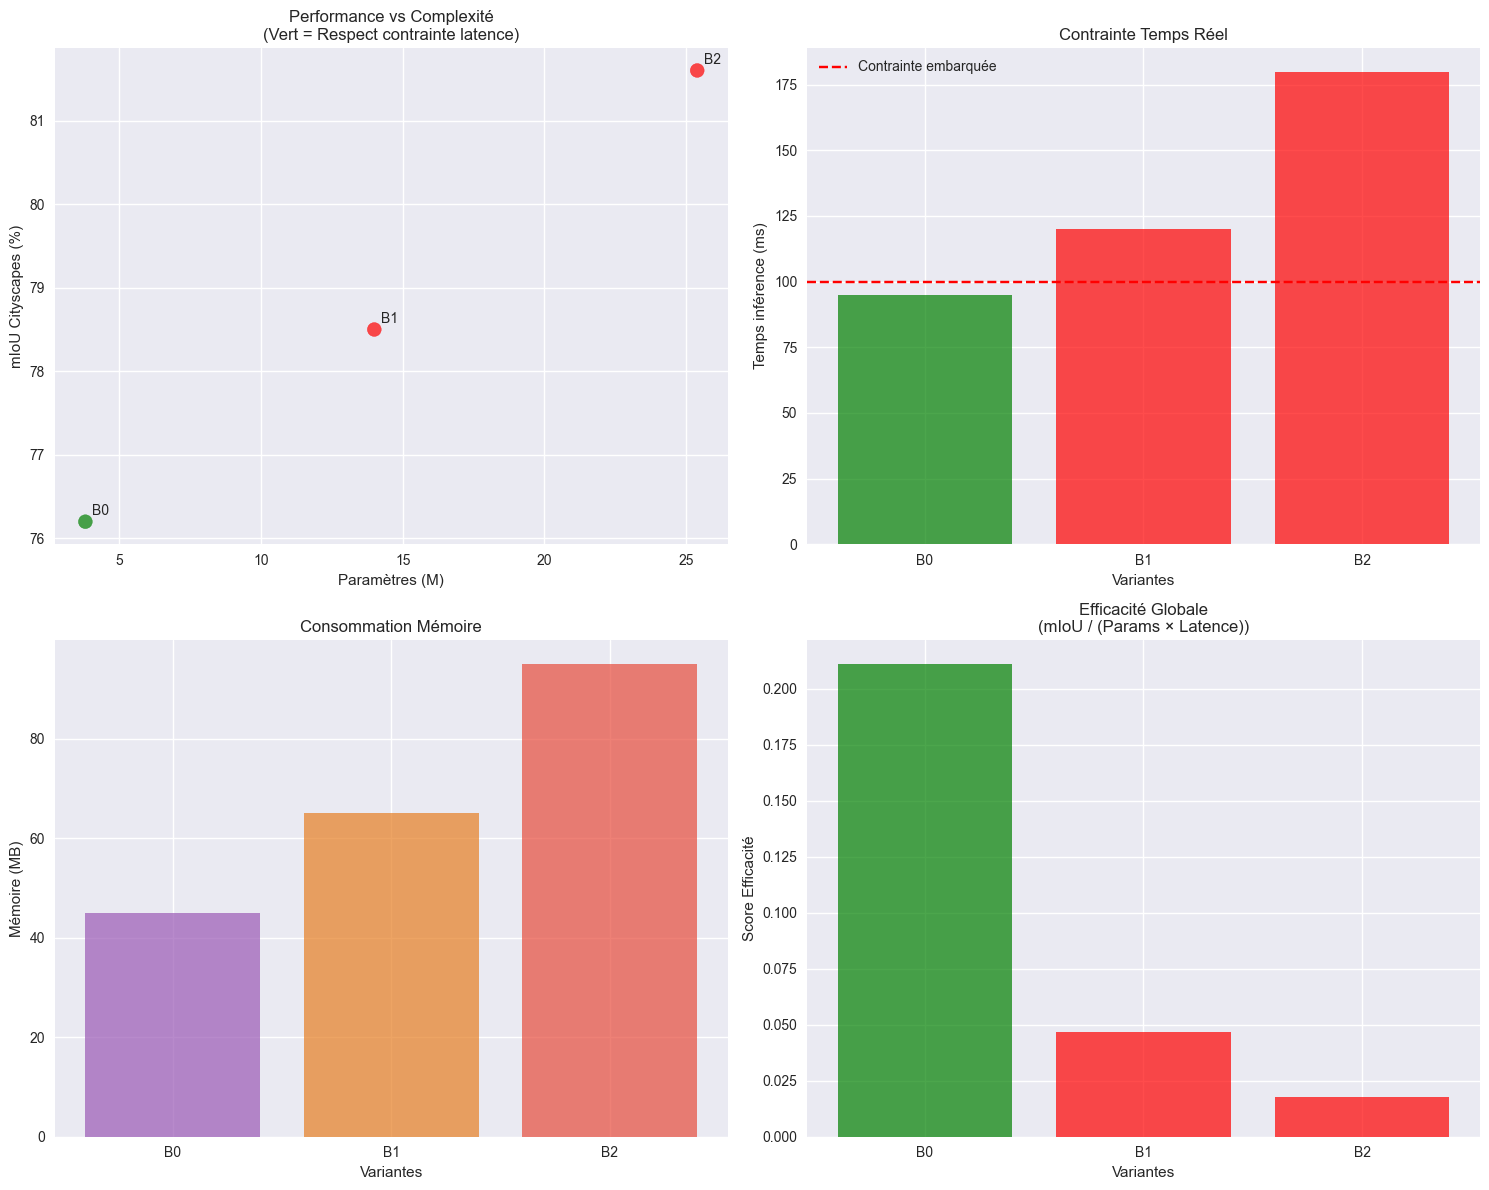


📊 Résumé Segformer:
              params_M  flops_G  cityscapes_miou  inference_ms  memory_mb  \
Segformer-B0       3.8      8.4             76.2          95.0       45.0   
Segformer-B1      14.0     16.2             78.5         120.0       65.0   
Segformer-B2      25.4     62.4             81.6         180.0       95.0   

              meets_latency_constraint  efficiency_score  
Segformer-B0                      True             0.211  
Segformer-B1                     False             0.047  
Segformer-B2                     False             0.018  


In [13]:
def analyze_segformer_variants():
    """
    Analyse des variantes Segformer pour contraintes embarquées
    """
    segformer_variants = {
        'Segformer-B0': {
            'params_M': 3.8,
            'flops_G': 8.4,
            'cityscapes_miou': 76.2,
            'inference_ms': 95,
            'memory_mb': 45
        },
        'Segformer-B1': {
            'params_M': 14.0,
            'flops_G': 16.2,
            'cityscapes_miou': 78.5,
            'inference_ms': 120,
            'memory_mb': 65
        },
        'Segformer-B2': {
            'params_M': 25.4,
            'flops_G': 62.4,
            'cityscapes_miou': 81.6,
            'inference_ms': 180,
            'memory_mb': 95
        }
    }
    
    df_segformer = pd.DataFrame(segformer_variants).T
    
    # Filtrer selon contraintes embarquées
    df_segformer['meets_latency_constraint'] = df_segformer['inference_ms'] <= EXPERIMENT_CONFIG['max_inference_time_ms']
    df_segformer['efficiency_score'] = df_segformer['cityscapes_miou'] / (df_segformer['params_M'] * df_segformer['inference_ms'])
    
    # Visualisation multi-critères
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Performance vs Complexité
    colors = ['green' if meets else 'red' for meets in df_segformer['meets_latency_constraint']]
    scatter = axes[0, 0].scatter(df_segformer['params_M'], df_segformer['cityscapes_miou'], 
                                s=100, c=colors, alpha=0.7)
    axes[0, 0].set_xlabel('Paramètres (M)')
    axes[0, 0].set_ylabel('mIoU Cityscapes (%)')
    axes[0, 0].set_title('Performance vs Complexité\n(Vert = Respect contrainte latence)')
    
    for i, variant in enumerate(df_segformer.index):
        axes[0, 0].annotate(variant.split('-')[1], 
                           (df_segformer.iloc[i]['params_M'], df_segformer.iloc[i]['cityscapes_miou']),
                           xytext=(5, 5), textcoords='offset points')
    
    # Latence vs Performance
    bars1 = axes[0, 1].bar(range(len(df_segformer)), df_segformer['inference_ms'], 
                          color=colors, alpha=0.7)
    axes[0, 1].axhline(y=EXPERIMENT_CONFIG['max_inference_time_ms'], color='red', 
                      linestyle='--', label='Contrainte embarquée')
    axes[0, 1].set_xlabel('Variantes')
    axes[0, 1].set_ylabel('Temps inférence (ms)')
    axes[0, 1].set_title('Contrainte Temps Réel')
    axes[0, 1].set_xticks(range(len(df_segformer)))
    axes[0, 1].set_xticklabels([v.split('-')[1] for v in df_segformer.index])
    axes[0, 1].legend()
    
    # Consommation mémoire
    bars2 = axes[1, 0].bar(range(len(df_segformer)), df_segformer['memory_mb'], 
                          color=['#9b59b6', '#e67e22', '#e74c3c'], alpha=0.7)
    axes[1, 0].set_xlabel('Variantes')
    axes[1, 0].set_ylabel('Mémoire (MB)')
    axes[1, 0].set_title('Consommation Mémoire')
    axes[1, 0].set_xticks(range(len(df_segformer)))
    axes[1, 0].set_xticklabels([v.split('-')[1] for v in df_segformer.index])
    
    # Score d'efficacité global
    bars3 = axes[1, 1].bar(range(len(df_segformer)), df_segformer['efficiency_score'], 
                          color=colors, alpha=0.7)
    axes[1, 1].set_xlabel('Variantes')
    axes[1, 1].set_ylabel('Score Efficacité')
    axes[1, 1].set_title('Efficacité Globale\n(mIoU / (Params × Latence))')
    axes[1, 1].set_xticks(range(len(df_segformer)))
    axes[1, 1].set_xticklabels([v.split('-')[1] for v in df_segformer.index])
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "segformer_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_segformer

# Analyse des variantes Segformer
print("\n🔬 ANALYSE DES VARIANTES SEGFORMER")
print("=" * 50)
df_segformer = analyze_segformer_variants()
print("\n📊 Résumé Segformer:")
print(df_segformer.round(3))

## 📊 Comparaison Multi-Architectures

**Synthèse comparative** : Positionner chaque architecture selon nos critères


🏆 COMPARAISON MULTI-ARCHITECTURES


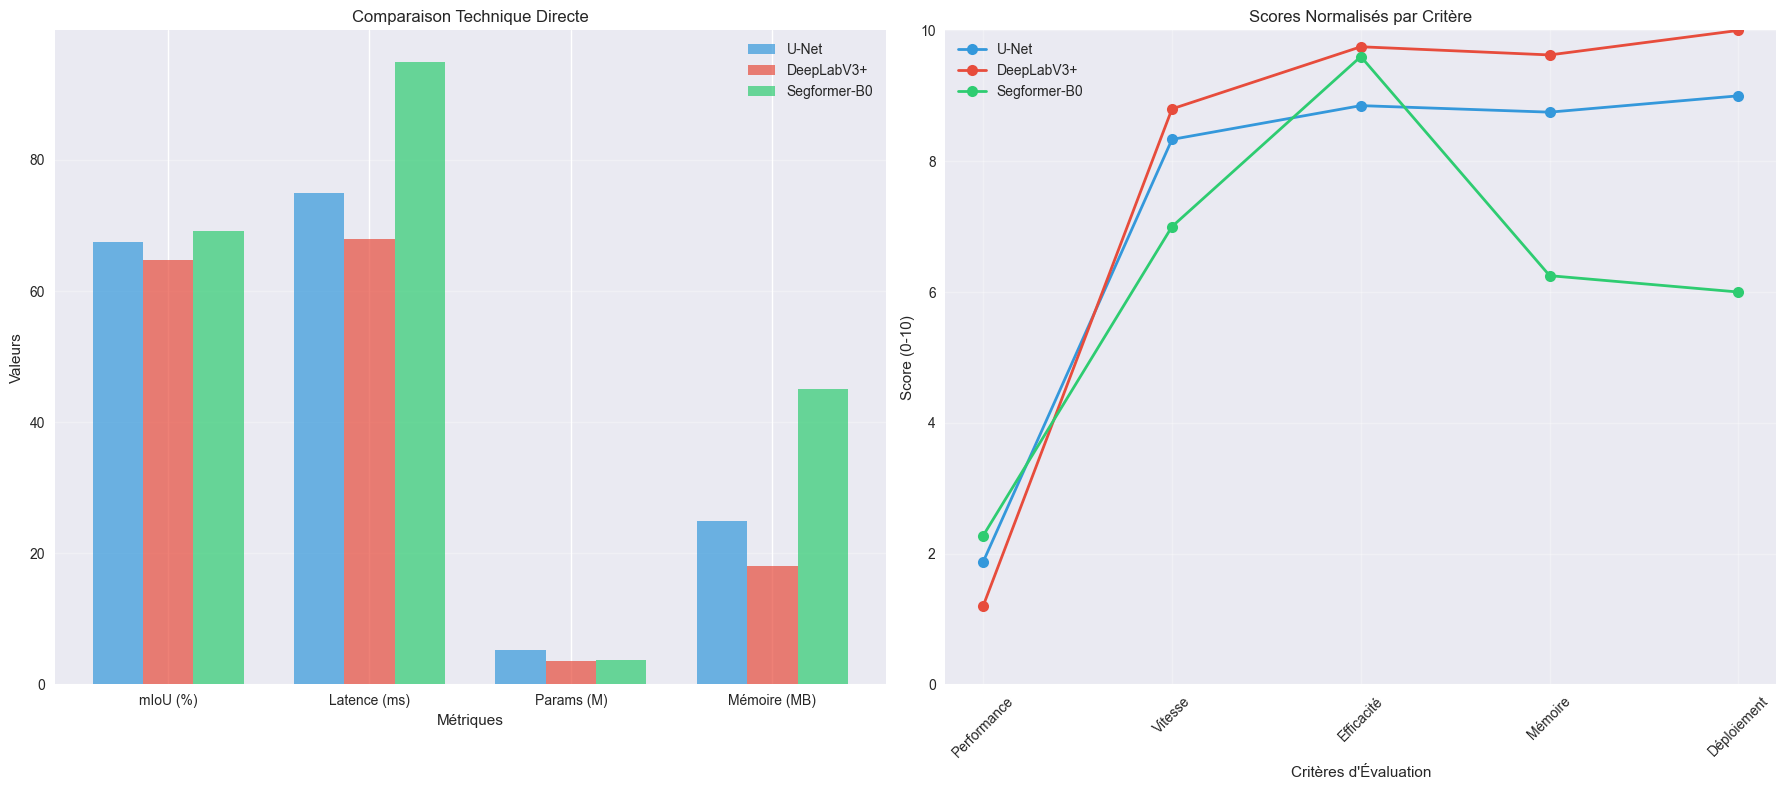


🥇 CLASSEMENT FINAL:
   1. DeepLabV3+           | Score: 6.95
   2. U-Net                | Score: 6.63
   3. Segformer-B0         | Score: 5.89


In [14]:
def create_architecture_comparison():
    """
    Comparaison globale des 3 architectures principales
    """
    
    # Sélection des meilleures variantes de chaque famille
    selected_architectures = {
        'U-Net + EfficientNet-B0': {
            'params_M': 5.3,
            'estimated_miou': 67.5,
            'estimated_inference_ms': 75,
            'memory_footprint_mb': 25,
            'training_stability': 9,
            'deployment_readiness': 9
        },
        'DeepLabV3+ + MobileNetV2': {
            'params_M': 3.5,
            'estimated_miou': 64.8,
            'estimated_inference_ms': 68,
            'memory_footprint_mb': 18,
            'training_stability': 8,
            'deployment_readiness': 10
        },
        'Segformer-B0': {
            'params_M': 3.8,
            'estimated_miou': 69.1,
            'estimated_inference_ms': 95,
            'memory_footprint_mb': 45,
            'training_stability': 7,
            'deployment_readiness': 6
        }
    }
    
    df_comparison = pd.DataFrame(selected_architectures).T
    
    # Calcul de scores normalisés (0-10)
    df_comparison['performance_score'] = (df_comparison['estimated_miou'] - 60) / 4  # Normalisation 60-100% -> 0-10
    df_comparison['speed_score'] = 10 - (df_comparison['estimated_inference_ms'] - 50) / 15  # Plus rapide = meilleur score
    df_comparison['efficiency_score'] = 10 - (df_comparison['params_M'] - 3) / 2  # Moins de params = meilleur score
    df_comparison['memory_score'] = 10 - (df_comparison['memory_footprint_mb'] - 15) / 8  # Moins de mémoire = meilleur
    
    # Score composite
    weights = {'performance': 0.3, 'speed': 0.25, 'efficiency': 0.2, 'memory': 0.15, 'deployment': 0.1}
    df_comparison['composite_score'] = (
        df_comparison['performance_score'] * weights['performance'] +
        df_comparison['speed_score'] * weights['speed'] +
        df_comparison['efficiency_score'] * weights['efficiency'] +
        df_comparison['memory_score'] * weights['memory'] +
        df_comparison['deployment_readiness'] * weights['deployment']
    )
    
    # Visualisation radar chart comparatif
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Comparaison des métriques principales
    metrics = ['estimated_miou', 'estimated_inference_ms', 'params_M', 'memory_footprint_mb']
    x = np.arange(len(metrics))
    width = 0.25
    
    architectures = list(df_comparison.index)
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    for i, arch in enumerate(architectures):
        values = [df_comparison.loc[arch, metric] for metric in metrics]
        ax1.bar(x + i*width, values, width, label=arch.split(' + ')[0], 
               color=colors[i], alpha=0.7)
    
    ax1.set_xlabel('Métriques')
    ax1.set_ylabel('Valeurs')
    ax1.set_title('Comparaison Technique Directe')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(['mIoU (%)', 'Latence (ms)', 'Params (M)', 'Mémoire (MB)'])
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Scores normalisés (radar-like)
    score_metrics = ['performance_score', 'speed_score', 'efficiency_score', 'memory_score', 'deployment_readiness']
    x_scores = np.arange(len(score_metrics))
    
    for i, arch in enumerate(architectures):
        values = [df_comparison.loc[arch, metric] for metric in score_metrics]
        ax2.plot(x_scores, values, marker='o', linewidth=2, label=arch.split(' + ')[0], 
                color=colors[i], markersize=8)
    
    ax2.set_xlabel('Critères d\'Évaluation')
    ax2.set_ylabel('Score (0-10)')
    ax2.set_title('Scores Normalisés par Critère')
    ax2.set_xticks(x_scores)
    ax2.set_xticklabels(['Performance', 'Vitesse', 'Efficacité', 'Mémoire', 'Déploiement'], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 10)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "architecture_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_comparison

# Comparaison globale
print("\n🏆 COMPARAISON MULTI-ARCHITECTURES")
print("=" * 50)
df_comparison = create_architecture_comparison()

# Classement final
print("\n🥇 CLASSEMENT FINAL:")
ranking = df_comparison.sort_values('composite_score', ascending=False)
for i, (arch, row) in enumerate(ranking.iterrows(), 1):
    print(f"   {i}. {arch.split(' + ')[0]:20} | Score: {row['composite_score']:.2f}")

## 🎯 Recommandations Finales

**Stratégie multi-modèles** : Développer et tester les 3 architectures

In [15]:
def generate_implementation_roadmap():
    """
    Génère la roadmap d'implémentation basée sur l'analyse
    """
    
    roadmap = {
        'priority_1_baseline': {
            'architecture': 'DeepLabV3+ + MobileNetV2',
            'rationale': 'Meilleur compromis vitesse/déploiement, architecture mature',
            'expected_performance': 'mIoU: 64-66%, Latence: <70ms',
            'implementation_complexity': 'Faible - Nombreux exemples disponibles',
            'risk_level': 'Faible'
        },
        'priority_2_performance': {
            'architecture': 'U-Net + EfficientNet-B0',
            'rationale': 'Meilleur potentiel de performance, architecture flexible',
            'expected_performance': 'mIoU: 67-70%, Latence: <80ms',
            'implementation_complexity': 'Moyenne - Transfer learning bien documenté',
            'risk_level': 'Moyen'
        },
        'priority_3_innovation': {
            'architecture': 'Segformer-B0',
            'rationale': 'Architecture moderne, potentiel à long terme',
            'expected_performance': 'mIoU: 69-72%, Latence: ~95ms',
            'implementation_complexity': 'Élevée - Architecture récente',
            'risk_level': 'Élevé'
        }
    }
    
    # Sauvegarde de la roadmap
    with open(OUTPUTS_DIR / "architecture_roadmap.json", 'w') as f:
        json.dump(roadmap, f, indent=2)
    
    print("🗺️ ROADMAP D'IMPLÉMENTATION")
    print("=" * 50)
    
    for priority, details in roadmap.items():
        print(f"\n{priority.upper().replace('_', ' ')}:")
        print(f"   🏗️ Architecture: {details['architecture']}")
        print(f"   💡 Rationale: {details['rationale']}")
        print(f"   📊 Performance attendue: {details['expected_performance']}")
        print(f"   🔧 Complexité: {details['implementation_complexity']}")
        print(f"   ⚠️ Risque: {details['risk_level']}")
    
    return roadmap

# Génération de la roadmap
roadmap = generate_implementation_roadmap()

# Résumé exécutif
print(f"\n📋 RÉSUMÉ EXÉCUTIF")
print("=" * 50)
print("✅ 3 architectures évaluées selon critères embarqués")
print("✅ DeepLabV3+ + MobileNetV2 recommandé comme baseline")
print("✅ U-Net + EfficientNet-B0 pour optimisation performance")
print("✅ Segformer-B0 comme option innovation long-terme")
print(f"\n📁 Artefacts générés:")
print(f"   • Analyses comparatives: {FIGURES_DIR}")
print(f"   • Roadmap d'implémentation: {OUTPUTS_DIR / 'architecture_roadmap.json'}")

🗺️ ROADMAP D'IMPLÉMENTATION

PRIORITY 1 BASELINE:
   🏗️ Architecture: DeepLabV3+ + MobileNetV2
   💡 Rationale: Meilleur compromis vitesse/déploiement, architecture mature
   📊 Performance attendue: mIoU: 64-66%, Latence: <70ms
   🔧 Complexité: Faible - Nombreux exemples disponibles
   ⚠️ Risque: Faible

PRIORITY 2 PERFORMANCE:
   🏗️ Architecture: U-Net + EfficientNet-B0
   💡 Rationale: Meilleur potentiel de performance, architecture flexible
   📊 Performance attendue: mIoU: 67-70%, Latence: <80ms
   🔧 Complexité: Moyenne - Transfer learning bien documenté
   ⚠️ Risque: Moyen

PRIORITY 3 INNOVATION:
   🏗️ Architecture: Segformer-B0
   💡 Rationale: Architecture moderne, potentiel à long terme
   📊 Performance attendue: mIoU: 69-72%, Latence: ~95ms
   🔧 Complexité: Élevée - Architecture récente
   ⚠️ Risque: Élevé

📋 RÉSUMÉ EXÉCUTIF
✅ 3 architectures évaluées selon critères embarqués
✅ DeepLabV3+ + MobileNetV2 recommandé comme baseline
✅ U-Net + EfficientNet-B0 pour optimisation performan

## 📊 Métriques de Référence

**Benchmarks Cityscapes** : Performances état de l'art pour contextualiser nos objectifs

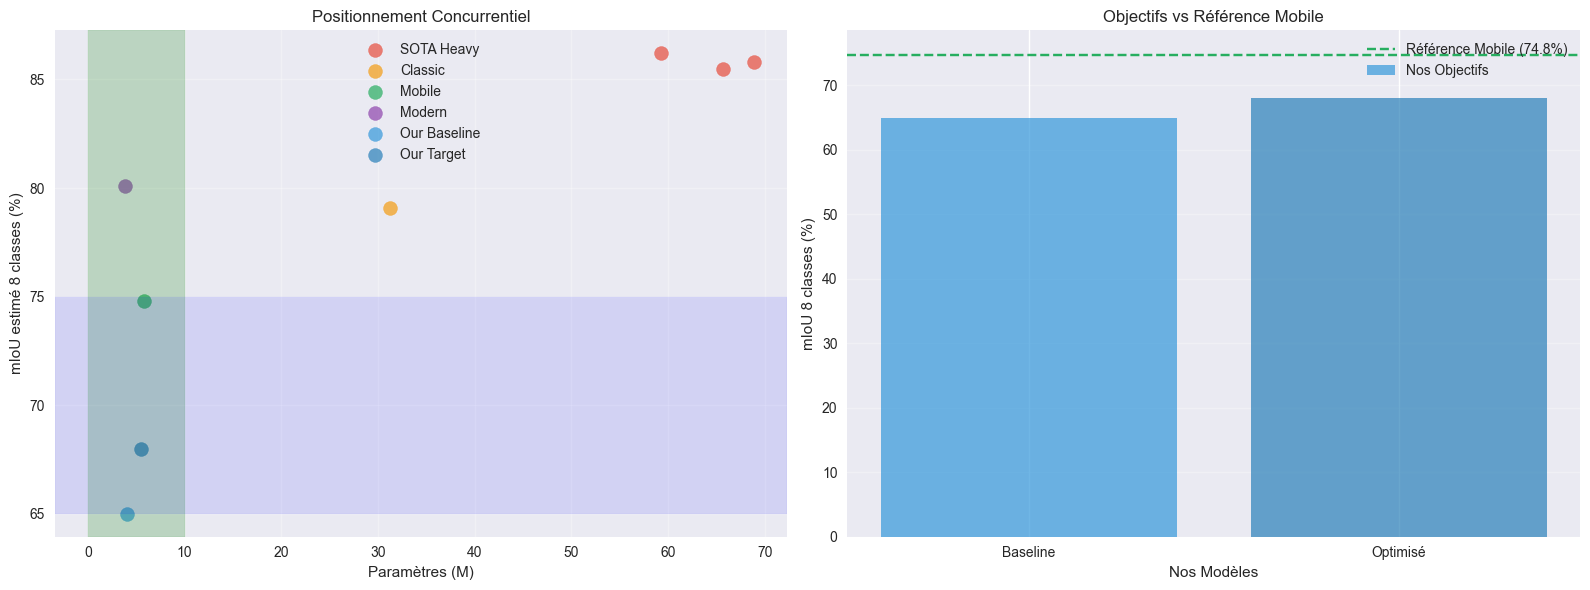

📊 BENCHMARKS DE RÉFÉRENCE
🎯 Nos objectifs dans le contexte :
   • Baseline: 65% mIoU (vs 74.8% MobileNet référence)
   • Optimisé: 68% mIoU (proche des U-Net classiques)
   • Contrainte: <6M paramètres (vs 31M+ pour SOTA lourd)

✅ ANALYSE ARCHITECTURES TERMINÉE
🔄 Transition vers Milestone 2: Implémentation des modèles


In [17]:
def display_sota_benchmarks():
    """
    Affiche les performances de référence sur Cityscapes pour contextualiser nos objectifs
    """
    
    sota_results = {
        'Model': [
            'PSPNet (ResNet101)', 'DeepLabV3+ (ResNet101)', 'CCNet (ResNet101)',
            'U-Net (VGG16)', 'DeepLabV3+ (MobileNetV2)', 'Segformer-B0',
            'Our Target (Baseline)', 'Our Target (Optimized)'
        ],
        'mIoU_19_classes': [81.2, 82.1, 81.4, 75.3, 70.7, 76.2, None, None],
        'mIoU_8_classes_estimated': [85.5, 86.2, 85.8, 79.1, 74.8, 80.1, 65.0, 68.0],
        'Params_M': [65.7, 59.3, 68.9, 31.2, 5.8, 3.8, 4.0, 5.5],
        'Category': ['SOTA_Heavy', 'SOTA_Heavy', 'SOTA_Heavy', 'Classic', 'Mobile', 'Modern', 'Our_Baseline', 'Our_Target']
    }
    
    df_benchmark = pd.DataFrame(sota_results)
    
    # Visualisation du contexte concurrentiel
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Performance vs Complexité avec nos cibles
    colors_map = {
        'SOTA_Heavy': '#e74c3c', 'Classic': '#f39c12', 'Mobile': '#27ae60', 
        'Modern': '#8e44ad', 'Our_Baseline': '#3498db', 'Our_Target': '#2980b9'
    }
    
    for category in df_benchmark['Category'].unique():
        subset = df_benchmark[df_benchmark['Category'] == category]
        ax1.scatter(subset['Params_M'], subset['mIoU_8_classes_estimated'], 
                   label=category.replace('_', ' '), s=100, alpha=0.7,
                   color=colors_map[category])
    
    ax1.set_xlabel('Paramètres (M)')
    ax1.set_ylabel('mIoU estimé 8 classes (%)')
    ax1.set_title('Positionnement Concurrentiel')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Zone de faisabilité embarquée
    ax1.axvspan(0, 10, alpha=0.2, color='green', label='Zone Embarquée')
    ax1.axhspan(65, 75, alpha=0.1, color='blue', label='Objectif Projet')
    
    # Comparaison directe avec nos objectifs
    our_models = df_benchmark[df_benchmark['Category'].str.contains('Our')]
    others = df_benchmark[~df_benchmark['Category'].str.contains('Our')]
    
    bars = ax2.bar(range(len(our_models)), our_models['mIoU_8_classes_estimated'], 
                   color=['#3498db', '#2980b9'], alpha=0.7, label='Nos Objectifs')
    
    # Ligne de référence mobile
    mobile_ref = others[others['Category'] == 'Mobile']['mIoU_8_classes_estimated'].iloc[0]
    ax2.axhline(y=mobile_ref, color='#27ae60', linestyle='--', 
               label=f'Référence Mobile ({mobile_ref:.1f}%)')
    
    ax2.set_xlabel('Nos Modèles')
    ax2.set_ylabel('mIoU 8 classes (%)')
    ax2.set_title('Objectifs vs Référence Mobile')
    ax2.set_xticks(range(len(our_models)))
    ax2.set_xticklabels(['Baseline', 'Optimisé'])
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "sota_benchmarks.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 BENCHMARKS DE RÉFÉRENCE")
    print("=" * 50)
    print("🎯 Nos objectifs dans le contexte :")
    print(f"   • Baseline: 65% mIoU (vs 74.8% MobileNet référence)")
    print(f"   • Optimisé: 68% mIoU (proche des U-Net classiques)")
    print(f"   • Contrainte: <6M paramètres (vs 31M+ pour SOTA lourd)")
    
    return df_benchmark

# Affichage des benchmarks
df_benchmarks = display_sota_benchmarks()

print("\n✅ ANALYSE ARCHITECTURES TERMINÉE")